## 6.3 ハーディング指標で市場をみる

### コード6.2 ライブラリの読み込みと本節であつかう共通データの読み込み

In [1]:
import os
import pandas as pd
import mplfinance as mpf 
os.makedirs('./output', exist_ok=True)

# 銘柄ごとの日次リターンデータの読み込みと、計算に必要な列の選択
stockDaily = pd.read_csv('./data/stockDaily.csv', parse_dates=['date'])
stockDaily['date'] = stockDaily['date'].dt.to_period('D')
stockDaily = stockDaily[['ticker','date','open','high','low', 'close', 'volume']]
print(stockDaily)


### コード6.3 銘柄 A0036 と K0070 の 2010年1月のローソク足チャートを作成するプログラム

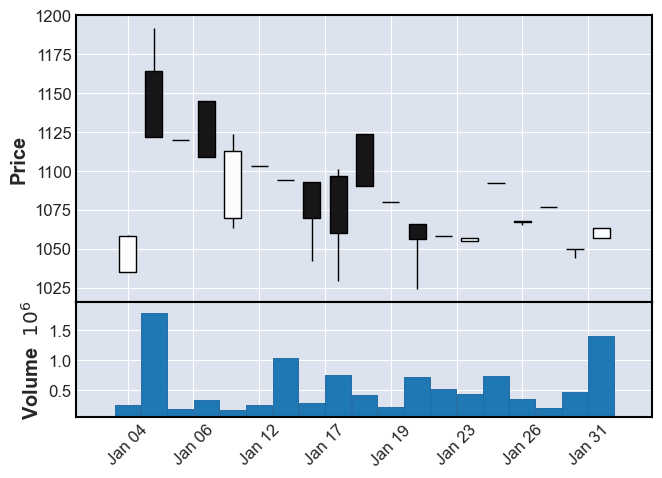

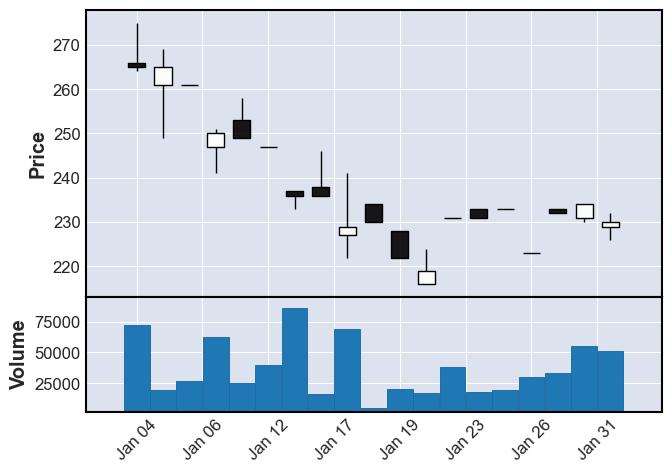

In [3]:
# 2つの銘柄A0036,K0070の2012年1月のローソク足チャート
# mpf.plotでは横軸の日付はDateTime型でなければならないので、
# dt.to_timestamp()で変換している。
df1 = stockDaily[stockDaily['ticker'] == 'A0036']
df1.index = df1['date'].dt.to_timestamp()
df1.drop(columns=['date']).sort_index()
df2 = stockDaily[stockDaily['ticker'] == 'K0070']
df2.index = df2['date'].dt.to_timestamp()
df2.drop(columns=['date']).sort_index()

df1 = df1.loc['2012-01']
df2 = df2.loc['2012-01']
mpf.plot(df1, type='candle', volume=True)
mpf.plot(df2, type='candle', volume=True)

### コード 6.4 2銘柄の価格推移の関係を折れ線チャートで描画するプログラム

            close_A36  close_K70  close_A36z  close_K70z
date                                                    
2012-01-04       1058        265   -0.966952    1.914275
2012-01-05       1122        265    1.723697    1.914275
2012-01-06       1120        261    1.639614    1.630125
2012-01-10       1109        250    1.177159    0.848712
2012-01-11       1113        249    1.345324    0.777674
2012-01-12       1103        247    0.924911    0.635599
2012-01-13       1094        236    0.546538   -0.145814
2012-01-16       1070        236   -0.462455   -0.145814
2012-01-17       1060        229   -0.882869   -0.643077
2012-01-18       1090        230    0.378373   -0.572039
2012-01-19       1080        222   -0.042041   -1.140339
2012-01-20       1056        219   -1.051035   -1.353452
2012-01-23       1058        231   -0.966952   -0.501002
2012-01-24       1057        231   -1.008993   -0.501002
2012-01-25       1092        233    0.462455   -0.358927
2012-01-26       1067        22

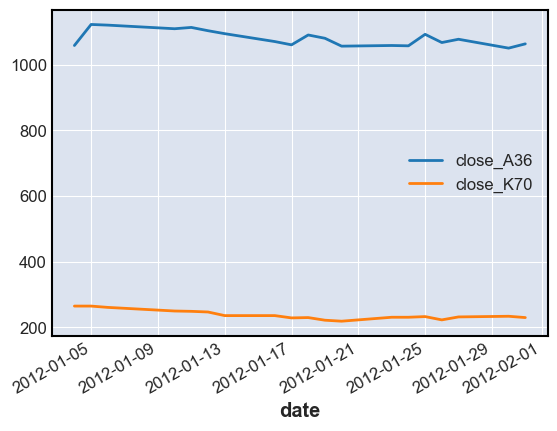

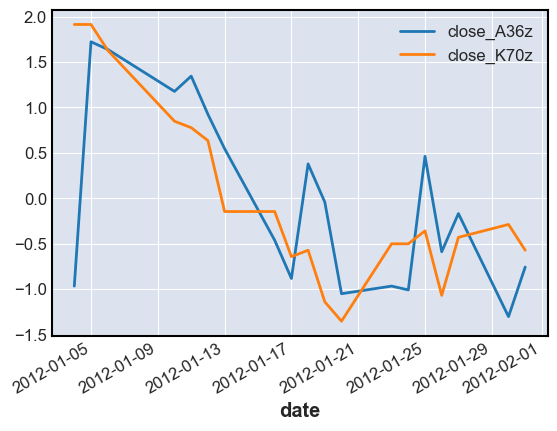

In [4]:
# dateを結合キーにしてdf1にdf2を結合する。
df = df1[['close']].join(df2[['close']], lsuffix='_A36', rsuffix='_K70')
# 2銘柄の終値をそのまま折れ線チャートで描画
ax=df.plot()
# 2銘柄の終値の単位を揃えるためにzscoreを求めて描画
# zscore(xi) = (xi-mean(x))/std(x)
df['close_A36z'] = ((df['close_A36'] - df['close_A36'].mean()) 
                    / df['close_A36'].std())
df['close_K70z'] = ((df['close_K70'] - df['close_K70'].mean()) 
                    / df['close_K70'].std())
ax = df[['close_A36z', 'close_K70z']].plot()
print(df)

### コード6.5 2つの銘柄の7つの特徴量に関する相関係数を計算する

{'open': 0.3543521245467162, 'high': 0.5597380355384446, 'low': 0.4164601366331016, 'close': 0.6054333182924909, 'volume': 0.13739464136495985, 'hml': 0.8784654311818565, 'cmo': -0.41833943025244263}


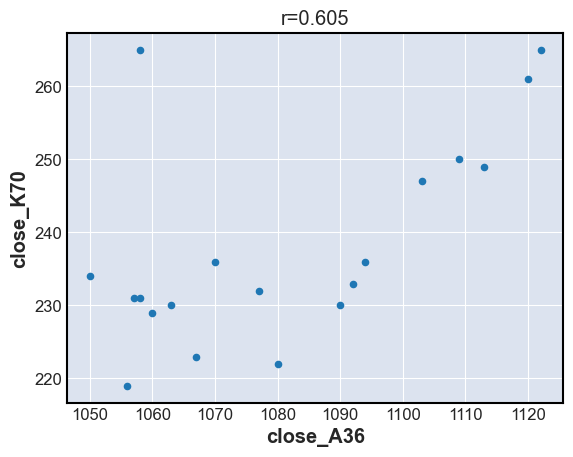

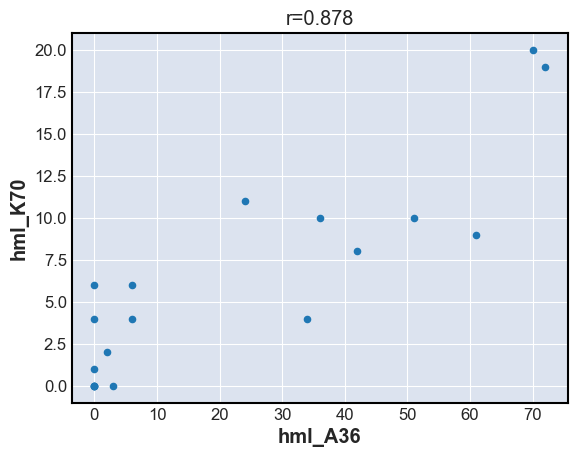

In [5]:
# 特徴量の追加(hml,cmo)
# high-lowで価格の揺れ幅を表現
df1['hml'] = df1['high'] - df1['low']
df2['hml'] = df2['high'] - df2['low']
# close-openでローソク足のボックスを表現
df1['cmo'] = df1['close'] - df1['open']
df2['cmo'] = df2['close'] - df2['open']

# 2銘柄のopen,high,low,close,volume,hml,cmoの系列間の相関係数を求める
cor={}
cor['open'] = df1['open'].corr(df2['open'])
cor['high'] = df1['high'].corr(df2['high'])
cor['low'] = df1['low'].corr(df2['low'])
cor['close'] = df1['close'].corr(df2['close'])
cor['volume'] = df1['volume'].corr(df2['volume'])
cor['hml'] = df1['hml'].corr(df2['hml'])
cor['cmo'] = df1['cmo'].corr(df2['cmo'])
print(cor)

# 散布図の描画
pds = df1.join(df2,lsuffix='_A36', rsuffix='_K70')
ax = pds.plot.scatter('close_A36', 'close_K70', title='r=%.3f' % cor['close'])
ax = pds.plot.scatter('hml_A36', 'hml_K70', title='r=%.3f' % cor['hml'])


----
### 銘柄間の相関行列を作成し、日別の銘柄連動指数(枝密度)を計算する。
----

In [ ]:
### 

In [6]:
# 2012年1月4日のticker数
tickers = stockDaily.loc[stockDaily['date'] == '2012-01-04', 'ticker'].unique()
print('len(tickers)', len(tickers))

# 2012年の営業日日数
dates = stockDaily.loc[(stockDaily['date'] >= '2012-01-01')
                & (stockDaily['date'] <= '2012-12-31'), 'date'].unique()
print('len(dates)',len(dates))

# Aで始まるticker数
tickersA = stockDaily.loc[stockDaily['ticker'].str[0] == 'A', 'ticker'].unique()
print('len(tickersA)', len(tickersA))

len(tickers) 2847
len(dates) 248
len(tickersA) 80


### コード6.6 Aから始まるtickerの終値データを作成する

In [7]:
## 図6-8の入力データ(1)の作成: ds1
# Aではじまるtickerの終値系列データをDataFrameとして作成
ds1 = stockDaily[['date', 'ticker', 'close']].copy()
ds1 = ds1[ds1['ticker'].str[0] == 'A']
print(ds1)

              date ticker  close
0       1991-01-04  A0001   1457
1       1991-01-07  A0001   1456
2       1991-01-08  A0001   1441
3       1991-01-09  A0001   1437
4       1991-01-10  A0001   1424
...            ...    ...    ...
351175  2014-12-24  A0080   1867
351176  2014-12-25  A0080   1880
351177  2014-12-26  A0080   1909
351178  2014-12-29  A0080   1858
351179  2014-12-30  A0080   1975

[351180 rows x 3 columns]


### コード6.7 ローリング・ウィンドウによるハーディング指数の計算

In [9]:
# 変動が類似する銘柄ペアをカウントする関数 # 図6-9の概要図を参照
def calCorr(win, ds):
    # rollingから送られてくる移動窓winのインデックスで元データds2を選択する
    # このようなindexによる選択ができるのは、dsとwinの行ラベルの対応が取れているからである。
    sel = ds.loc[win.index]
    cor1 = sel.corr() # 相関行列
    cor2 = cor1.stack() # 縦型変換
    # 下三角行列の選択 & 閾値による選択
    cor3 = cor2[cor2.index.get_level_values(0) < cor2.index.get_level_values(1)]
    cor3 = cor3[cor3 > 0.9]
    pairs = len(cor3) # 行数のカウント
    return pairs


## 図6-8のds2の作成
# date×tickerの終値行列の作成 
ds2 = ds1.pivot_table(index='date', columns='ticker', values='close')
print(ds2)

## 図6-8のsrの作成
# A0001列を切り出しているが、その内容は使わず、インデックス(date)を使うことが目的
sr = ds2['A0001']

## 図6-8のcorrを作成
# rollingの実行を実行し、各移動窓の結果(連動銘柄ペア数)が日別に得られる
corr = sr.rolling(10).apply(calCorr, args=(ds2,), raw=False)
corr = corr.dropna()
corr.name = 'corr'
print(corr)

ticker       A0001    A0002   A0003   A0004   A0005    A0006   A0007   A0008  \
date                                                                           
1991-01-04  1457.0      NaN     NaN  4675.0  1560.0  10931.0     NaN  2087.0   
1991-01-07  1456.0      NaN     NaN  4582.0  1558.0  10934.0     NaN  2099.0   
1991-01-08  1441.0      NaN     NaN  4747.0  1583.0  11021.0     NaN  2074.0   
1991-01-09  1437.0      NaN     NaN  4642.0  1549.0  10824.0     NaN  2070.0   
1991-01-10  1424.0      NaN     NaN  4614.0  1523.0  10532.0     NaN  2108.0   
...            ...      ...     ...     ...     ...      ...     ...     ...   
2014-12-24  1488.0  19827.0  2215.0   899.0  1355.0  11144.0  2148.0  2225.0   
2014-12-25  1505.0  19773.0  2191.0   890.0  1351.0  11083.0  2109.0  2218.0   
2014-12-26  1533.0  19856.0  2215.0   894.0  1361.0  11125.0  2104.0  2216.0   
2014-12-29  1480.0  19668.0  2124.0   901.0  1333.0  11085.0  2045.0  2190.0   
2014-12-30  1549.0  19779.0  2133.0   91

### コード6.8 変動が類似する銘柄数と市場の値動きの関係を視覚化するプログラム

## ffDaily
             RMRF   SMB   HML    RF   index
date                                      
1990-07-02 -0.08  1.46 -0.73  0.03   -0.05
1990-07-03 -0.40  0.65 -0.41  0.03   -0.42
1990-07-04  1.49 -0.01  0.32  0.03    1.10
1990-07-05  0.16  2.71 -0.12  0.03    1.29
1990-07-06  1.17  0.74 -0.03  0.03    2.49
...          ...   ...   ...   ...     ...
2015-06-24  1.05 -0.50 -0.15  0.00  147.28
2015-06-25  0.61 -0.04 -0.38  0.00  147.89
2015-06-26  0.92 -0.16  0.11  0.00  148.81
2015-06-29  0.05 -0.16  0.01  0.00  148.86
2015-06-30 -0.87 -0.04  0.17  0.00  147.99

[6149 rows x 5 columns]
## corr
 date
1991-01-18     2.0
1991-01-21     2.0
1991-01-22     5.0
1991-01-23     8.0
1991-01-24     9.0
              ... 
2014-12-24    46.0
2014-12-25    52.0
2014-12-26    68.0
2014-12-29    40.0
2014-12-30    46.0
Freq: D, Name: corr, Length: 5894, dtype: float64
## results
             corr  RMRF   SMB   HML    RF   index
date                                            
1991-01-18   2.0  0.0

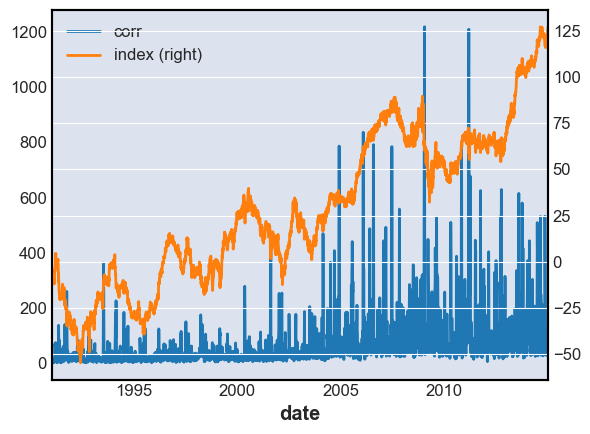

In [27]:
## 図6-8のffDailyの作成
# RMRFを市場インデックスとして利用するために、
# Fama-French 3ファクター・モデル用データを読み込む
ffDaily = pd.read_csv('./data/ffDaily.csv', parse_dates=['date'])
ffDaily['date'] = ffDaily['date'].dt.to_period('D')
ffDaily = ffDaily.set_index('date').sort_index()


## 図6-8のffDailyの作成のindex列作成
# RMRFは日次のリターンなので、累積を求めることで市場全体の時系列的変動を表すことができる
ffDaily['index'] = (ffDaily['RMRF']+ffDaily['RF']).cumsum()
print('## ffDaily\n', ffDaily)
print('## corr\n', corr)

## 図6-8のresultの作成
# ペア数にRMRF累積値を結合する
result = pd.DataFrame(corr).join(ffDaily)
print('## results\n', result)

## 図6-10の折れ線チャートの描画
ax = result[['corr', 'index']].plot(secondary_y=['index'])